Depois de termos rodado o notebook para preparar as imagens, fazemos as importações necessárias para darmos continuidade no projeto

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

Vamos trabalhar com o redimensionamento das imagens para 150px por 150px

In [2]:
IMG_HEIGHT = 150
IMG_WIDTH = 150

Criamos o modelo, com 10 camadas:
As 6 primeiras formam 3 grupos sequenciais (Convolução - Ativação ReLu - Pooling), depois uma camada de achatamento (flattening) é aplicada e em seguida uma camada de dropout (para reduzir o overfitting) de 30%. E no final uma camada fully connected (dense) é aplicada juntamente com a camada final que retorna a probabilidade de cada classe (com ou sem máscara).

In [3]:
model = tf.keras.models.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.3), 
    Dense(256, activation='relu'),
    Dense(2, activation='softmax') # Camada densa tem dimensão 2 pois temos apenas 2 classes 
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

acc = 0
val_loss = 0
val_acc = 0
loss = 0
val_loss = 0
epochs = 30

In [4]:
def trainModel():
    training_dir = "data/train"
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(training_dir, 
                                                      batch_size=10, 
                                                      target_size=(IMG_WIDTH, IMG_HEIGHT))
    validation_dir = "data/validation"
    validation_datagen = ImageDataGenerator(rescale=1.0/255)
    validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                           batch_size=10, 
                                                           target_size=(IMG_WIDTH, IMG_HEIGHT))
    checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

    history = model.fit_generator(train_generator,
                                epochs=epochs,
                                validation_data=validation_generator,
                                callbacks=[checkpoint])
    global acc
    acc = history.history['accuracy']
    global val_acc
    val_acc = history.history['val_accuracy']
    global loss
    loss = history.history['loss']
    global val_loss
    val_loss = history.history['val_loss']

In [5]:
def plot():
    epochs_range = range(epochs)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de treino')
    plt.plot(epochs_range, val_acc, label='Acurácia de validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia - Treino e validação')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda (treino)')
    plt.plot(epochs_range, val_loss, label='Perda (validação)')
    plt.legend(loc='upper right')
    plt.title('Perda - Treino e validação')
    plt.show()

Treinamento do modelo (rodando 30 épocas (epoch))

In [6]:
trainModel()

Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8500WARNING:tensorflow:From c:\users\bruno\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model\assets
110/110 [==============================] - 16s 145ms/step - loss: 0.3876 - accuracy: 0.8500 - val_loss: 0.1763 - val_accuracy: 0.9384
Epoch 2/30
110/110 [==============================] - 15s 138m

Plotando os resultados do treinamento (evolução do modelo durante as épocas)

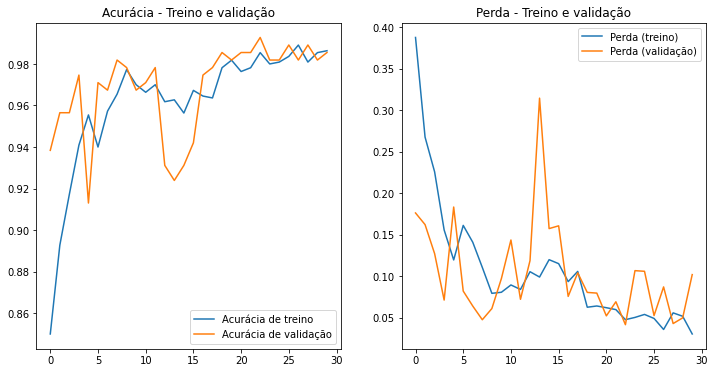

In [7]:
plot()

In [8]:
# Inicializa a webcam para a detecção em tempo real do uso ou não de máscara
# Visto isso no repositório: https://github.com/mk-gurucharan/Face-Mask-Detection 

face_clsfr = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [11]:
labels_dict = {0:'sem mascara',1:'com mascara'}
color_dict = {0:(0,0,255),1:(0,255,0)}

size = 3
webcam = cv2.VideoCapture(0)
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im = cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for (x, y, w, h) in faces:
        face_img = im[y:(y+h)*size, x:(x+w) * size]
        resized=cv2.resize(face_img,(IMG_WIDTH, IMG_HEIGHT))
        normalized = resized / 255.0
        reshaped = np.reshape(normalized,(1,IMG_WIDTH,IMG_HEIGHT,3))
        reshaped = np.vstack([reshaped])
        result = model.predict(reshaped)
        
        label = np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x* size,y* size),((x+w)* size,(y+h)* size),color_dict[label],2)
        cv2.rectangle(im,(x * size,(y* size)-40),((x+w)* size,y* size),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x* size + 10, (y* size)-10),cv2.FONT_HERSHEY_DUPLEX,0.8,(255,255,255),2)
        
    cv2.imshow('Deteccao de uso de mascara', im)
    key = cv2.waitKey(10)
    if key == 27:
        break
webcam.release()
cv2.destroyAllWindows()

In [12]:
model.save("mascara.h5")